### Modeling with Logistic Regression 

Goal: Classify magic cards by color using their text and logistic regression)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
import sklearn.metrics as sk

import pandas as pd
from collections import Counter
import numpy as np
import nltk

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [3]:
modern = pd.read_pickle('data/5color_modern_no_name_hardmode.pkl')

In [4]:
Counter(modern.colors)

Counter({u'Black': 1576,
         u'Blue': 1573,
         u'Green': 1566,
         u'Red': 1575,
         u'White': 1584})

After all the data munging the classes are still amazingly balanced.

#### Lets single out blue and red for a binary classification


In [9]:
UG = modern.loc[modern['colors'].isin(['Blue', 'Red'])]

UG.reset_index(inplace=True)
UG.pop('index')

UG[['name', 'colors', 'cmc', 'text']].sample(6)

,name,colors,cmc,text
2649,Pinnacle of Rage,Red,6,This deals 3 damage to each of two target crea...
3042,Send to Sleep,Blue,2,Tap up to two target creatures. Spell mastery ...
363,Fumiko the Lowblood,Red,4,"This has bushido X, where X is the number of a..."
2313,Turn to Slag,Red,5,This deals 5 damage to target creature. Destro...
949,Delay,Blue,2,Counter target spell. If the spell is countere...
405,Veil of Secrecy,Blue,2,Target creature gains shroud until end of turn...


In [10]:
dummies = pd.get_dummies(UG.colors)
# dummies['Green']

In [11]:
vectorizer = CountVectorizer()

vec_X = vectorizer.fit_transform(UG['text'])

X_train, X_test, y_train, y_test = train_test_split(vec_X, dummies['Red'],
                                             random_state=42)

print "There are {:,} words in the vocabulary.".format(len(vectorizer.vocabulary_))

There are 815 words in the vocabulary.


In [12]:
# Linear regression 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
mses = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='mean_squared_error') * -1

acc = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 0.094, Accuracy: 0.906


90% accuracy! these two colors were the ones I thought would be most different, but I never would have guessed they would be this easy to classify

#### Lets try naive bayes

In [9]:
# Multinomial naive bayes
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

mses = cross_val_score(nb, X_train, y_train,
                       cv=10, scoring='mean_squared_error') * -1

acc = cross_val_score(nb, X_train, y_train,
                       cv=10, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 0.151, Accuracy: 0.849


In [10]:
# Bernoulli naive bayes
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()

mses = cross_val_score(bnb, X_train, y_train,
                       cv=10, scoring='mean_squared_error') * -1

acc = cross_val_score(bnb, X_train, y_train,
                       cv=10, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 0.15, Accuracy: 0.85


Not as good as logistic regression

### Green vs All Five

The next step is separating green from a mix of all the colors

In [78]:
y = pd.get_dummies(modern.colors)['Green']

X = vectorizer.fit_transform(modern.text)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print "There are {:,} words in the vocabulary.".format(len(vectorizer.vocabulary_))

There are 1,161 words in the vocabulary.


In [79]:
# Logistic regression 

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver = 'lbfgs', multi_class='multinomial')

mses = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='mean_squared_error') * -1

acc = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 0.137, Accuracy: 0.863


In [80]:
# Multinomial naive bayes

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
mses = cross_val_score(nb, X_train, y_train,
                       cv=10, scoring='mean_squared_error') * -1

acc = cross_val_score(nb, X_train, y_train,
                       cv=10, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 0.172, Accuracy: 0.828


### All Five Vs All Five

And now the main event. Five way classification of all the colors.

In [14]:
modern['bincolor'] = pd.Categorical.from_array(modern.colors).codes

In [15]:
vectorizer = CountVectorizer()

y = modern.bincolor

X = vectorizer.fit_transform(modern.text)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print "There are {:,} words in the vocabulary.".format(len(vectorizer.vocabulary_))

There are 1,161 words in the vocabulary.


In [21]:
clf = LogisticRegression(C=2, multi_class='ovr', solver='liblinear')

mses = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='mean_squared_error') * -1

acc = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 1.505, Accuracy: 0.702


70% Accuracy with one vs rest and multinomial. Different solvers changed processing time, but not accuracy.

Not bad for choosing one out of five categories, but can we improve it? 

First, what went wrong? 


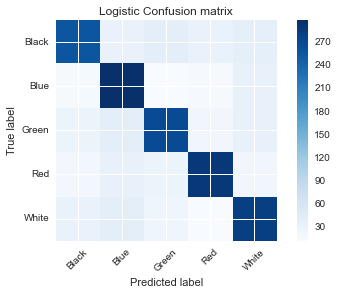

In [67]:
clf.fit(X_train, y_train)

label = ["Black", "Blue", "Green", "Red", "White"]

cm = sk.confusion_matrix(y_test, clf.predict(X_test), labels=None)

# plot code adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, title='Logistic Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(label))
    plt.xticks(tick_marks, label, rotation=45)
    plt.yticks(tick_marks, label)    
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)   

Black and Green seem to be the colors hardest to classify. White and black seem to be the colors most often picked in error. 

In [68]:
def show_most_informative_features(vectorizor, clf, n=30):
    feature_names = vectorizor.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)

show_most_informative_features(vectorizer, clf)

	-2.4767	vigilance      		4.1249	fear           
	-2.0940	gain           		3.7348	swamps         
	-2.0759	reach          		3.0853	discards       
	-1.8800	artifacts      		3.0124	sacrifices     
	-1.8680	attack         		2.7692	deathtouch     
	-1.8329	bloodrush      		2.7267	madness        
	-1.7887	enchantments   		2.6756	swampwalk      
	-1.7850	blocking       		2.6012	lose           
	-1.7179	having         		2.5118	rats           
	-1.6980	fights         		2.5012	nonblack       
	-1.6718	soldier        		2.3586	intimidate     
	-1.6326	draw           		2.2773	life           
	-1.6308	basic          		2.2034	delve          
	-1.6050	enchantment    		2.1742	zombie         
	-1.5908	base           		2.1418	loses          
	-1.5753	hands          		2.0497	black          
	-1.5337	aura           		2.0140	rogue          
	-1.4986	renown         		1.8896	phylactery     
	-1.4738	untap          		1.8737	extort         
	-1.4539	plains         		1.8732	theft          
	-1.4296	copy       

#### Without Commons

Commons are the most basic cards. Almost always they have the least text. Could accuracy be improved by skipping them? 

In [24]:
modern['bincolor'] = pd.Categorical.from_array(modern.colors).codes

a = modern.groupby('rarity').get_group('Uncommon')
b = modern.groupby('rarity').get_group('Rare')
c = modern.groupby('rarity').get_group('Mythic Rare')
no_commons = pd.concat([a,b,c])


no_commons['bincolor'] = pd.Categorical.from_array(no_commons.colors).codes

vectorizer = CountVectorizer()

y = no_commons.bincolor

X = vectorizer.fit_transform(no_commons.text)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print "There are {:,} words in the vocabulary.".format(len(vectorizer.vocabulary_))

clf = LogisticRegression(C=2, multi_class='ovr', solver='liblinear')

mses = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='mean_squared_error') * -1

acc = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

There are 1,047 words in the vocabulary.
MSE: 1.669, Accuracy: 0.688


A slight decrease in accuracy, nothing to see here

### Just for Fun: Classification by Flavor Text

Some cards have text below their abilities with quotes and stories from the world. They have absolutely no effect on the game, but can be fun to read. 

In [69]:
vectorizer = CountVectorizer(stop_words="english")

flavor_df = modern[pd.notnull(modern.flavor)]

y = flavor_df.bincolor

X = vectorizer.fit_transform(flavor_df.flavor)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print "There are {:,} words in the vocabulary.".format(len(vectorizer.vocabulary_))

There are 10,767 words in the vocabulary.


In [70]:
clf = LogisticRegression(C=1)

mses = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='mean_squared_error') * -1

acc = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 2.395, Accuracy: 0.54


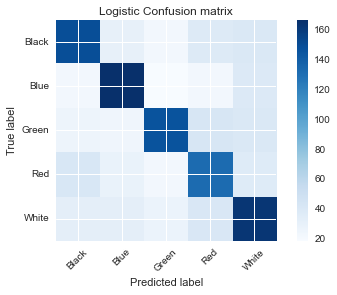

In [71]:
clf.fit(X_train, y_train)

cm = sk.confusion_matrix(y_test, clf.predict(X_test), labels=None)

plot_confusion_matrix(cm)  

In [73]:
show_most_informative_features(vectorizer, clf)

	-1.3655	nature         		1.9806	liliana        
	-1.1212	flame          		1.6831	swamp          
	-1.1140	forest         		1.6378	sheoldred      
	-1.1099	goblin         		1.6215	dark           
	-1.0553	people         		1.5893	silumgar       
	-0.9955	times          		1.5846	weak           
	-0.9814	glory          		1.5644	victims        
	-0.9562	rage           		1.5617	rats           
	-0.9338	safety         		1.5003	death          
	-0.9312	easy           		1.4906	pharika        
	-0.9039	goblins        		1.4846	nightmares     
	-0.9023	sky            		1.4718	geth           
	-0.8970	want           		1.4278	undeath        
	-0.8761	kithkin        		1.4015	feast          
	-0.8717	ground         		1.3849	dead           
	-0.8703	defend         		1.3560	victim         
	-0.8622	home           		1.3455	cruelty        
	-0.8578	enemies        		1.3351	dimir          
	-0.8558	dragon         		1.3180	grave          
	-0.8523	wolf           		1.3102	vile           
	-0.8440	song       